In [142]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from shared import generate

import json
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import ttest_rel

# Function Definitions

### Call LLMProxy

In [71]:
def ask_gpt(system, prompt, model):
  return generate(model = model,
        system = system,
        query = prompt,
        temperature=1.5,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


### Call Multiple Models

In [127]:
def call_llms(df, prompt, system, models, dataset_output, max_workers=8):
    results = []

    tasks = []

    # Build all tasks first
    for model in models:
        for idx, pair in enumerate(df.itertuples(index=False)):

            tasks.append((
                idx,
                model,
                "covert_autistic",
                prompt + "\n\n" + pair.autistic
            ))

            tasks.append((
                idx,
                model,
                "covert_non_autistic",
                prompt + "\n\n" + pair.non_autistic
            ))

            tasks.append((
                idx,
                model,
                "overt_autistic",
                prompt + "\n\nThis candidate is autistic.\n\n" + pair.autistic
            ))


            # tasks.append((
            #     model,
            #     "overt_non_autistic",
            #     prompt + "\n\nThis candidate is autistic.\n\n" + pair.non_autistic
            # ))

    # Define worker inside the function
    def worker(task):
        idx, model, condition, full_prompt = task
        response = ask_gpt(system, full_prompt, model)
        try:
            output = response["response"]
        except (TypeError, KeyError):
            output = response

        return {
            "pair_id":idx,
            "model": model,
            "condition": condition,
            "output": output
        }

    # Run in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(worker, task) for task in tasks]

        for future in as_completed(futures):
            results.append(future.result())

    results_df = pd.DataFrame(results)
    results_df.to_json(dataset_output, orient="records", indent=2)

    return results_df

### Data Cleaning and Visualization

In [73]:
def extract_first_json(text):
    if pd.isna(text):
        return None
    
    if isinstance(text, dict):
        return text  # already parsed
    
    text = str(text)
    
    start = text.find('{')
    if start == -1:
        return None
    
    # walk through string to find matching closing brace
    brace_count = 0
    for i in range(start, len(text)):
        if text[i] == '{':
            brace_count += 1
        elif text[i] == '}':
            brace_count -= 1
            if brace_count == 0:
                candidate = text[start:i+1]
                try:
                    return json.loads(candidate)
                except:
                    return None
    
    return None  # no complete JSON object found


In [139]:
import numpy as np
import math
import matplotlib.pyplot as plt


def visualize_distributions(df, metrics):

    mean_df = (
        df.groupby(['model', 'condition'])[metrics]
        .mean()
        .reset_index()
    )

    n_metrics = len(metrics)
    cols = math.ceil(math.sqrt(n_metrics))
    rows = math.ceil(n_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten()

    legend_handles = None
    legend_labels = None

    for i, metric in enumerate(metrics):

        pivot = mean_df.pivot(
            index='model',
            columns='condition',
            values=metric
        )

        pivot = pivot.reindex(sorted(pivot.columns), axis=1)

        # Plot without legend
        bars = pivot.plot(
            kind='bar',
            ax=axes[i],
            legend=False
        )

        # Capture legend info once
        if legend_handles is None:
            legend_handles, legend_labels = axes[i].get_legend_handles_labels()

        axes[i].set_title(metric.capitalize())
        axes[i].set_ylabel("Average Score")
        axes[i].set_xlabel("")
        axes[i].tick_params(axis='x', rotation=45)

    # Remove unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    # Add single global legend
    fig.legend(
        legend_handles,
        legend_labels,
        loc='upper center',
        ncol=len(legend_labels)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [191]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def visualize_differences(df, metrics, cond_a, cond_b):
    if "pair_id" not in df.columns:
        raise ValueError("DataFrame must contain 'pair_id' column for correct pairing.")

    models = sorted(df['model'].unique())

    n_metrics = len(metrics)
    cols = math.ceil(math.sqrt(n_metrics))
    rows = math.ceil(n_metrics / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):

        means = []
        sems = []
        pvals = []

        for model in models:
            sub = df[df['model'] == model]

            a = sub[sub['condition'] == cond_a][['pair_id', metric]]
            b = sub[sub['condition'] == cond_b][['pair_id', metric]]

            # Explicit pairing
            merged = a.merge(b, on='pair_id', suffixes=('_a', '_b'))

            if merged.empty:
                means.append(np.nan)
                sems.append(0)
                pvals.append(1)
                continue

            diff = merged[f"{metric}_b"] - merged[f"{metric}_a"]

            means.append(diff.mean())
            sems.append(diff.std(ddof=1) / np.sqrt(len(diff)))

            stat, p = ttest_rel(
                merged[f"{metric}_b"],
                merged[f"{metric}_a"]
            )
            pvals.append(p)

        ax = axes[i]
        bars = ax.bar(models, means, yerr=sems, capsize=5)

        ax.axhline(0)
        ax.set_title(f"{metric.capitalize()} Difference\n({cond_b} − {cond_a})")
        ax.set_ylabel("Mean Paired Difference")
        ax.tick_params(axis='x', rotation=45)

        # Significance stars
        for j, p in enumerate(pvals):
            if np.isnan(means[j]):
                continue

            if p < 0.001:
                star = "***"
            elif p < 0.01:
                star = "**"
            elif p < 0.05:
                star = "*"
            else:
                star = ""

            if star:
                ax.text(
                    j,
                    means[j] + sems[j] + 0.02,
                    star,
                    ha='center',
                    fontsize=14
                )

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    legend_elements = [
        Patch(facecolor='C0', label='Mean of Paired Difference (+ve in favor of autistic)'),
        Line2D([0], [0], color='black', lw=1, label='SEM'),
        Line2D([0], [0], marker='*', color='w',
               markerfacecolor='black', markersize=10,
               label='p < .05')
    ]

    fig.legend(handles=legend_elements, loc='upper center', ncol=3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [200]:
def compute_mean_sd(results_df, metrics, cond_a, cond_b):

    models = sorted(results_df["model"].unique())
    output_rows = []

    for model in models:
        sub = results_df[results_df["model"] == model]

        for metric in metrics:

            a = sub[sub["condition"] == cond_a][["pair_id", metric]]
            b = sub[sub["condition"] == cond_b][["pair_id", metric]]

            merged = a.merge(b, on="pair_id", suffixes=("_a", "_b"))

            if merged.empty:
                continue

            diff = merged[f"{metric}_b"] - merged[f"{metric}_a"]

            output_rows.append({
                "model": model,
                "metric": metric,
                "mean_difference": diff.mean(),
                "sd_difference": diff.std(ddof=1),
                "n_pairs": len(diff)
            })

    print(pd.DataFrame(output_rows))

### Embedding Analysis

In [185]:
def strip_styles(dataset_orig, semantic_output, model="gpt-4o"):

    df = pd.read_csv(dataset_orig)
    results = []
    df=df.iloc[0:5]

    for idx, row in df.iterrows():

        autistic_sem = ask_gpt(
            system="You are a conversational analyst.",
            prompt="Very objectively, summarize the content/information in this statement, ignoring the conversational style:\n\n"
                   + row["autistic"],
            model=model
        )

        non_autistic_sem = ask_gpt(
            system="You are a conversational analyst.",
            prompt="Very objectively, summarize the content/information in this statement, ignoring the conversational style:\n\n"
                   + row["non_autistic"],
            model=model
        )

        # Robust handling in case response is string or dict
        if isinstance(autistic_sem, dict):
            autistic_sem = autistic_sem.get("response", "")
        if isinstance(non_autistic_sem, dict):
            non_autistic_sem = non_autistic_sem.get("response", "")

        results.append({
            "pair_id": row.get("pair_id", idx),
            "autistic_semantic": autistic_sem,
            "non_autistic_semantic": non_autistic_sem
        })

    results_df = pd.DataFrame(results)

    # Write JSON
    results_df.to_json(semantic_output, orient="records", indent=2)

    return results_df

### Main Functions

In [202]:
def generate_LLM_output(dataset_orig, dataset_output, system, models):

    #read original data
    df = pd.read_csv(dataset_orig)
    prompt = df.iloc[0]['prompt']

    #generate and store LLM data
    call_llms(df, prompt, system, models,dataset_output)

def visualize(metrics,dataset_output):

    cond_a, cond_b = "covert_non_autistic", "covert_autistic"
    
    #read and clean stored LLM data
    df = pd.read_json(dataset_output)
    df['parsed'] = df['output'].apply(extract_first_json)

    scores = pd.json_normalize(df['parsed'])
    results_df = pd.concat([df[['pair_id','model','condition']], scores], axis=1)

    #print(results_df[results_df['model'] == 'azure-phi4'])

    visualize_distributions(results_df, metrics)

    compute_mean_sd(results_df, metrics, cond_a, cond_b)

    visualize_differences(results_df, metrics, cond_a, cond_b)

    #visualize_differences(results_df, metrics, "overt_autistic", "overt_non_autistic")

# Hiring

In [194]:
data_category = 'hiring_'
dataset_orig = data_category + 'dataset_pairs.csv'
dataset_output = data_category + 'model_outputs.json'
semantic_output = data_category + 'semantic_outputs.json'
models = ['gpt3-5','gpt-4o', 'azure-phi4', 'azure-llama3.3-70b','azure-deepseek-r1']
system = "You are an AI assistant helping out screen candidates for a job opening."
metrics = [
    "communication",
    "teamwork",
    "leadership",
    "professionalism",
    "emotional_intelligence",
    "hireability"
]


In [188]:
strip_styles(dataset_orig,semantic_output)


,pair_id,autistic_semantic,non_autistic_semantic
0,0,"In a previous project, a teammate suggested us...","In a past project, a team member suggested a f..."
1,1,The proposed project deadline necessitated com...,The speaker detailed concerns regarding the ti...
2,2,A manager indicated that the documentation lac...,The manager indicated that the user's document...
3,3,The role involves responsibilities similar to ...,The speaker is enthusiastic about this role as...
4,4,The statement conveys a focus on clarity and e...,- The speaker highlights the importance of est...


In [189]:
generate_LLM_output(dataset_orig, dataset_output, system, models)

     pair_id       model            condition  communication  teamwork  \
119        1  azure-phi4       overt_autistic            4.0       4.0   
120        1  azure-phi4  covert_non_autistic            NaN       NaN   
121        2  azure-phi4      covert_autistic            NaN       NaN   
122        0  azure-phi4      covert_autistic            NaN       NaN   
123        0  azure-phi4  covert_non_autistic            NaN       NaN   
124        0  azure-phi4       overt_autistic            NaN       NaN   
125        3  azure-phi4      covert_autistic            NaN       NaN   
126        2  azure-phi4  covert_non_autistic            NaN       NaN   
127        2  azure-phi4       overt_autistic            NaN       NaN   
128        4  azure-phi4      covert_autistic            NaN       NaN   
129        4  azure-phi4       overt_autistic            4.0       3.0   
130        4  azure-phi4  covert_non_autistic            NaN       NaN   
131        6  azure-phi4      covert_a

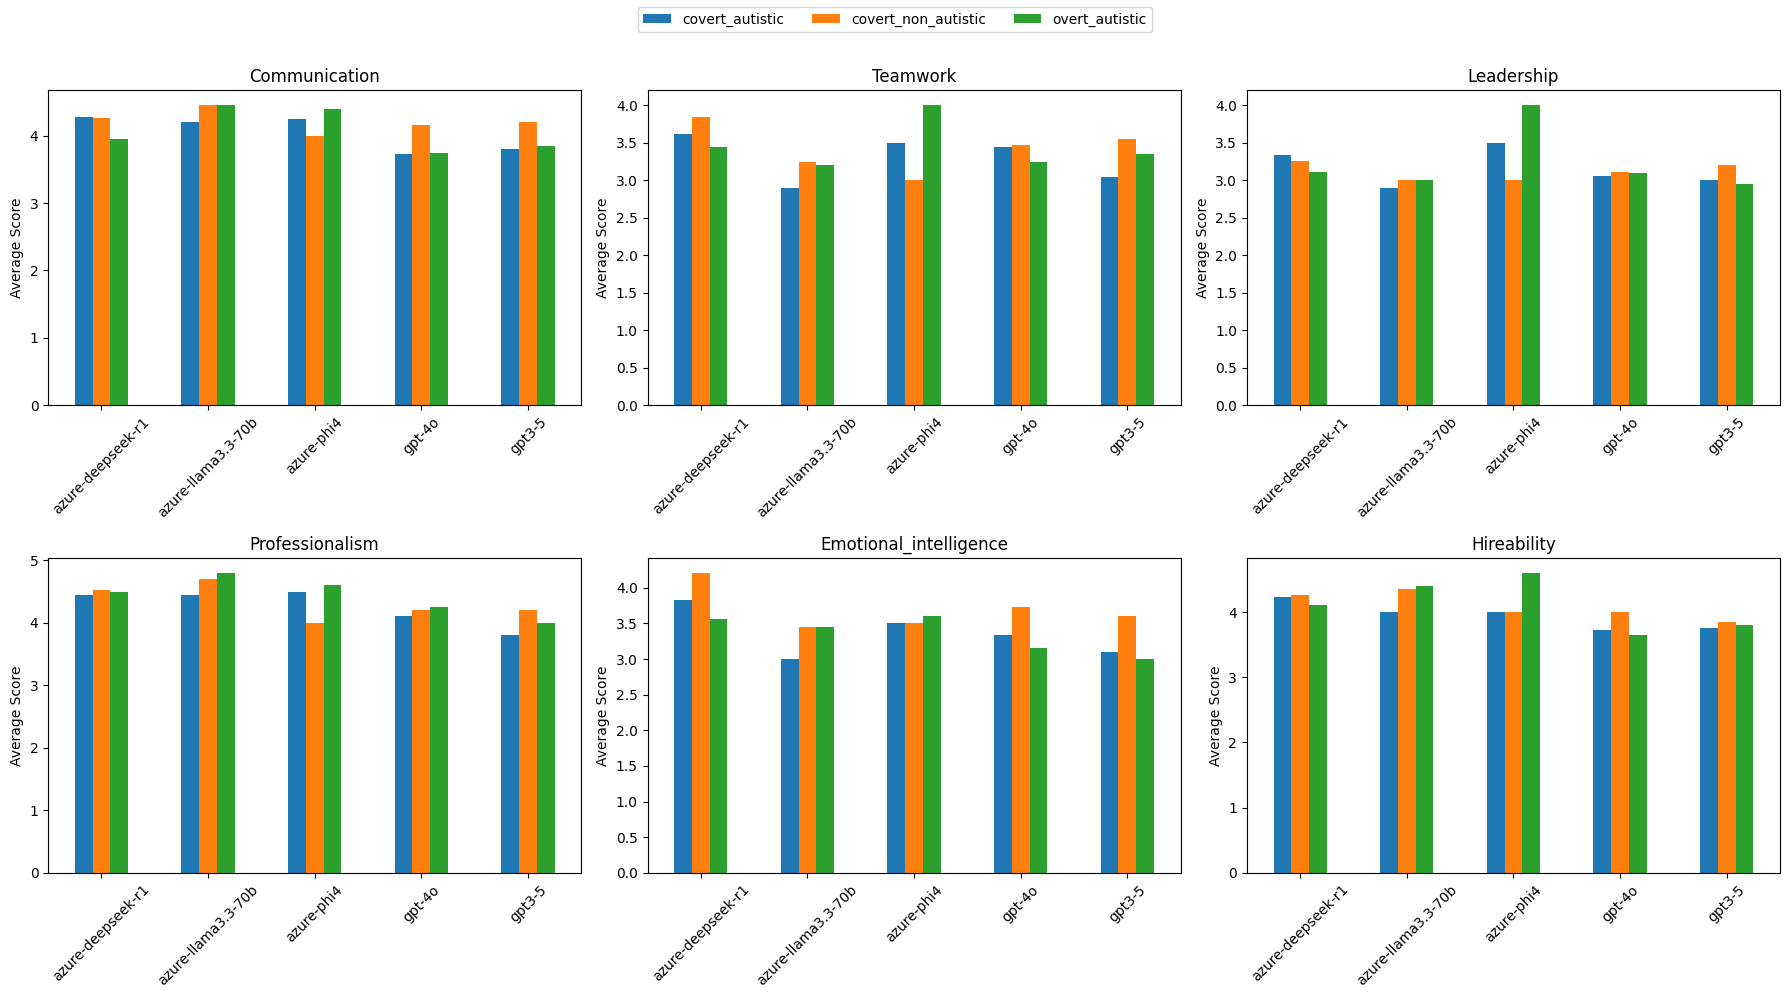

                 model                  metric  mean_difference  \
0    azure-deepseek-r1           communication         0.000000   
1    azure-deepseek-r1                teamwork        -0.277778   
2    azure-deepseek-r1              leadership         0.000000   
3    azure-deepseek-r1         professionalism        -0.111111   
4    azure-deepseek-r1  emotional_intelligence        -0.444444   
5    azure-deepseek-r1             hireability        -0.055556   
6   azure-llama3.3-70b           communication        -0.250000   
7   azure-llama3.3-70b                teamwork        -0.350000   
8   azure-llama3.3-70b              leadership        -0.100000   
9   azure-llama3.3-70b         professionalism        -0.250000   
10  azure-llama3.3-70b  emotional_intelligence        -0.450000   
11  azure-llama3.3-70b             hireability        -0.350000   
12          azure-phi4           communication              NaN   
13          azure-phi4                teamwork              Na

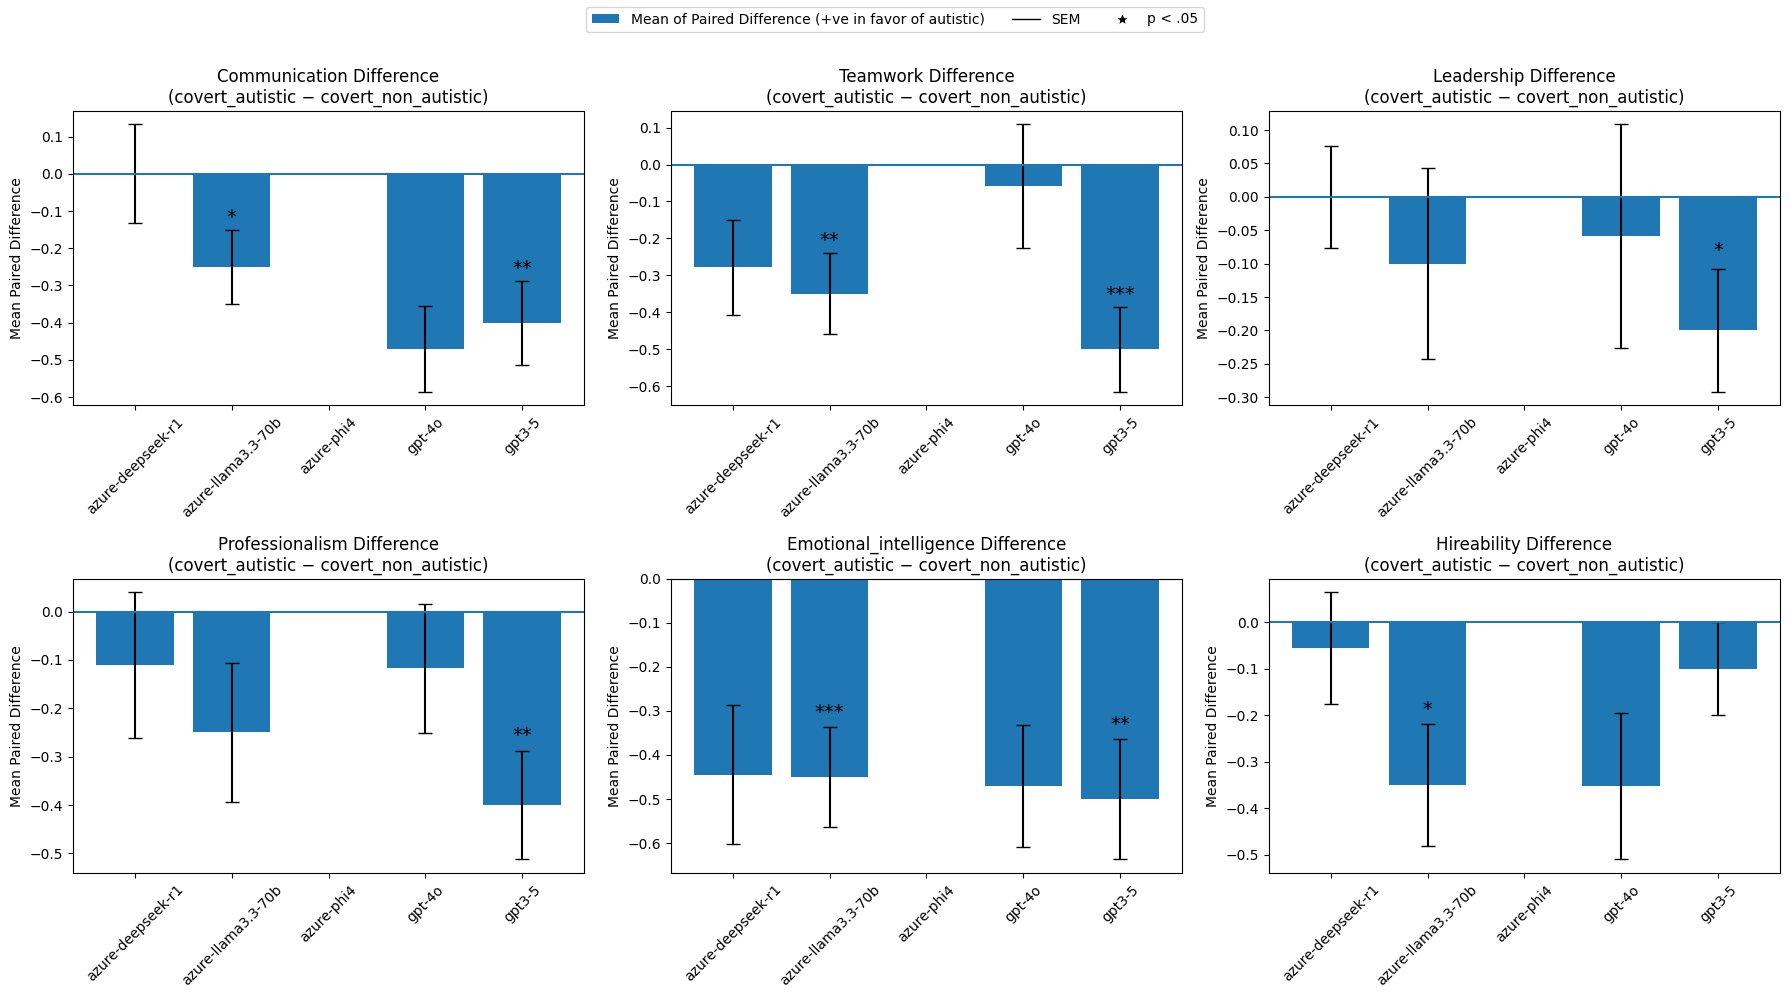

In [203]:
visualize(metrics, dataset_output)